In [1]:
import pandas as pd
import numpy as np
import csv
from copy import deepcopy
from pandas import datetime
from copy import deepcopy
import gc
import random
import datetime
import csv
from copy import deepcopy
from os import listdir
from os.path import isfile, join, isdir
from tqdm import tqdm_notebook
from Downloader import Extractor
from Preprocessing import Preprocessor, set_onelevel, set_multilevel
from Filters import XGBFilter
from Filters import quantile_huber_loss, quantile_huber_obj 
import pickle
import xgboost as xgb

/home/anna/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# getting file tree in directory "data_csv", which contains raw unfiltered data
mypath = './data_csv/Raw/'
dateparse = pd.to_datetime
station_files = [f for f in listdir(mypath) if isfile(join(mypath, f)) if int(f.split('_', 1)[0])]
station_files.sort()

# reading loaded csv files from data_csv directory, output is a list (length=number of stations) of raw df 
raw_lmeteo_list = [pd.read_csv(mypath + '/' + station, index_col=0, 
                    dtype={'station_id': int,'date_time': str}, 
                    date_parser = dateparse, parse_dates = ['date_time']) 
                   for station in tqdm_notebook(station_files[:6])]

#fix problems with indexing, later this will be solved in loading part
for elem in raw_lmeteo_list:
    elem.reset_index(drop=True, inplace=True)

raw_data = pd.concat(raw_lmeteo_list)
raw_data['id'] = random.sample(range(len(raw_data)), len(raw_data))
raw_data['valid'] = True
raw_data = raw_data.reset_index(drop=True)

del raw_lmeteo_list
gc.collect()

raw_data

,station_data_id,sensor_id,data,station_id,sensor_type_id,active_state,name,rule_id,rule_ordr,direction,lane_traffic,date_time,poll_interval,fake_data,type,unit_of_measure,description,id,valid
0,7137045.0,6032.0,7357.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,pressure,NaN,pressure (sw),207507,True
1,7137045.0,6021.0,140.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_road,NaN,t_road (sw),1303197,True
2,7137045.0,6020.0,136.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_air,NaN,t_air (sw),436729,True
3,7137045.0,6022.0,140.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,t_underroad,NaN,t_underroad (sw),8999,True
4,7137045.0,6023.0,831.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-17 18:01:48,NaN,NaN,dampness,NaN,dampness (sw),974289,True
5,7137243.0,6032.0,7398.0,113,16.0,A,NaN,152.0,36.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,pressure,NaN,pressure (sw),1373683,True
6,7137243.0,6021.0,194.0,113,2.0,A,NaN,154.0,14.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_road,NaN,t_road (sw),297242,True
7,7137243.0,6020.0,156.0,113,1.0,A,NaN,4.0,12.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_air,NaN,t_air (sw),932728,True
8,7137243.0,6022.0,187.0,113,3.0,A,NaN,155.0,16.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,t_underroad,NaN,t_underroad (sw),197164,True
9,7137243.0,6023.0,664.0,113,4.0,A,NaN,6.0,18.0,0.0,0.0,2012-09-18 14:33:21,NaN,NaN,dampness,NaN,dampness (sw),1100825,True


In [3]:
%%time
preprocessor = Preprocessor()
meteo_splitted = preprocessor.PivotTable(raw_data)
# del raw_data

patterns_list = preprocessor.CreatePatternList(meteo_splitted)
# del pivoted_df

patterns_interpolated = preprocessor.InterpolatePatterns(patterns_list)
# del patterns_list

patterns_lagged = preprocessor.CreateLaggedTable(patterns_interpolated)
# del patterns_interpolated

final = pd.concat(patterns_lagged).reset_index(drop=True)

CPU times: user 1min 25s, sys: 276 ms, total: 1min 25s
Wall time: 1min 25s


In [ ]:
final.columns

MultiIndex(levels=[['data_dampness', 'data_pressure', 'data_t_air', 'data_t_road', 'data_t_underroad', 'date_time', 'id_dampness', 'id_pressure', 'id_t_air', 'id_t_road', 'id_t_underroad', 'station_id', 'valid_dampness', 'valid_pressure', 'valid_t_air', 'valid_t_road', 'valid_t_underroad'], [-6.0, -5.5, -5.0, -4.5, -4.0, -3.5, -3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0]],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 11, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17

In [4]:
# dampness = final['data_dampness']

X = final['data_t_air'].iloc[1:10000]

# dampness.shape

In [5]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager
from sklearn import svm

# dampness = final['data_dampness']

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit_transform(X)

min_val =  X.min().min()
max_val =  X.max().max()
axis_val = np.linspace(min_val, max_val, 500)

xx, yy = np.meshgrid(axis_val, axis_val)

Automatically created module for IPython interactive environment


In [6]:
clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)
y_pred_train = clf.predict(X)

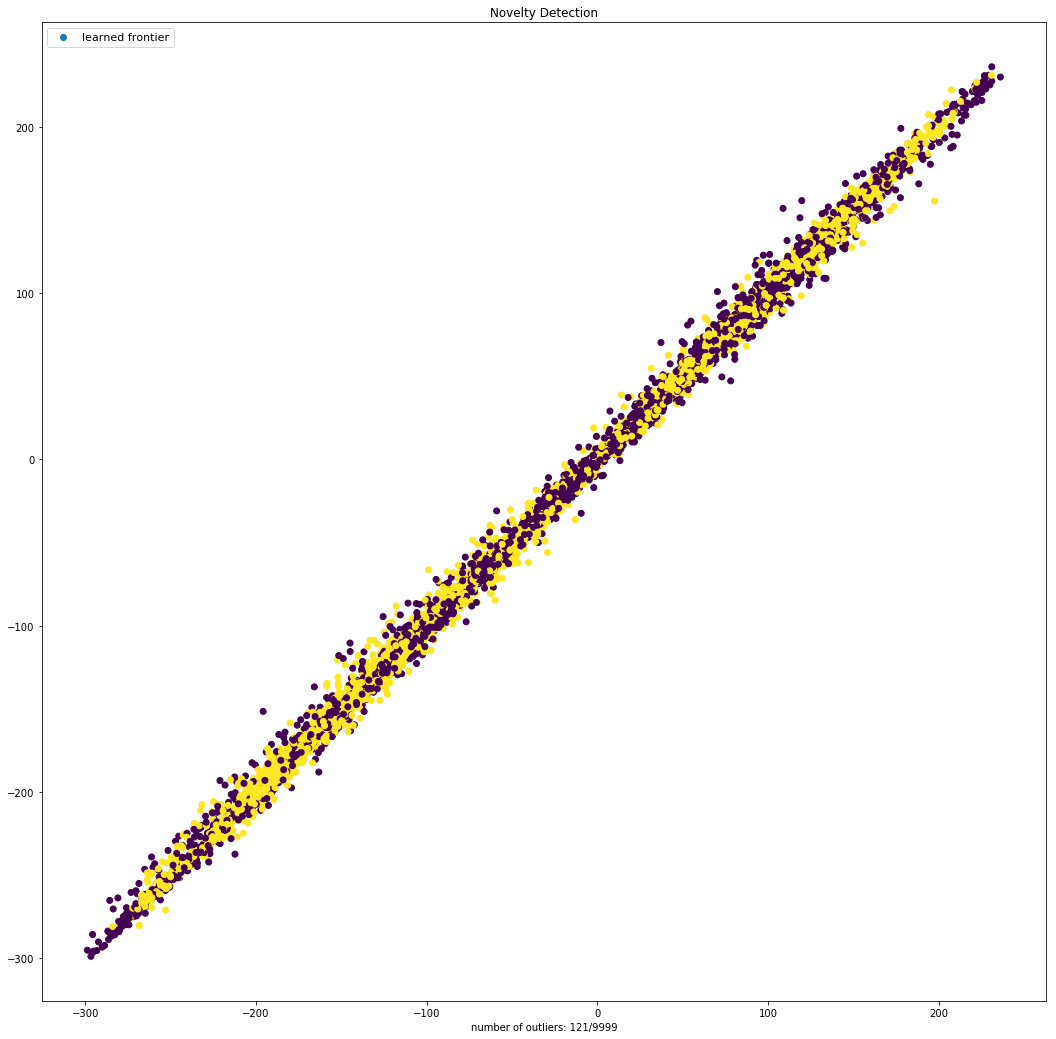

In [11]:
# plot the line, the points, and the nearest vectors to the plane
# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

plt.figure(figsize=(18, 18))

plt.title("Novelty Detection")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (y_pred_train.sum() , len(X.index)))

plt.show()


In [8]:
from sklearn.covariance import EllipticEnvelope
clf_ee = EllipticEnvelope()
clf_ee.fit(X)
y_pred_train_ee = clf_ee.predict(X)

In [9]:
np.not_equal(y_pred_train, y_pred_train_ee).sum()

4953

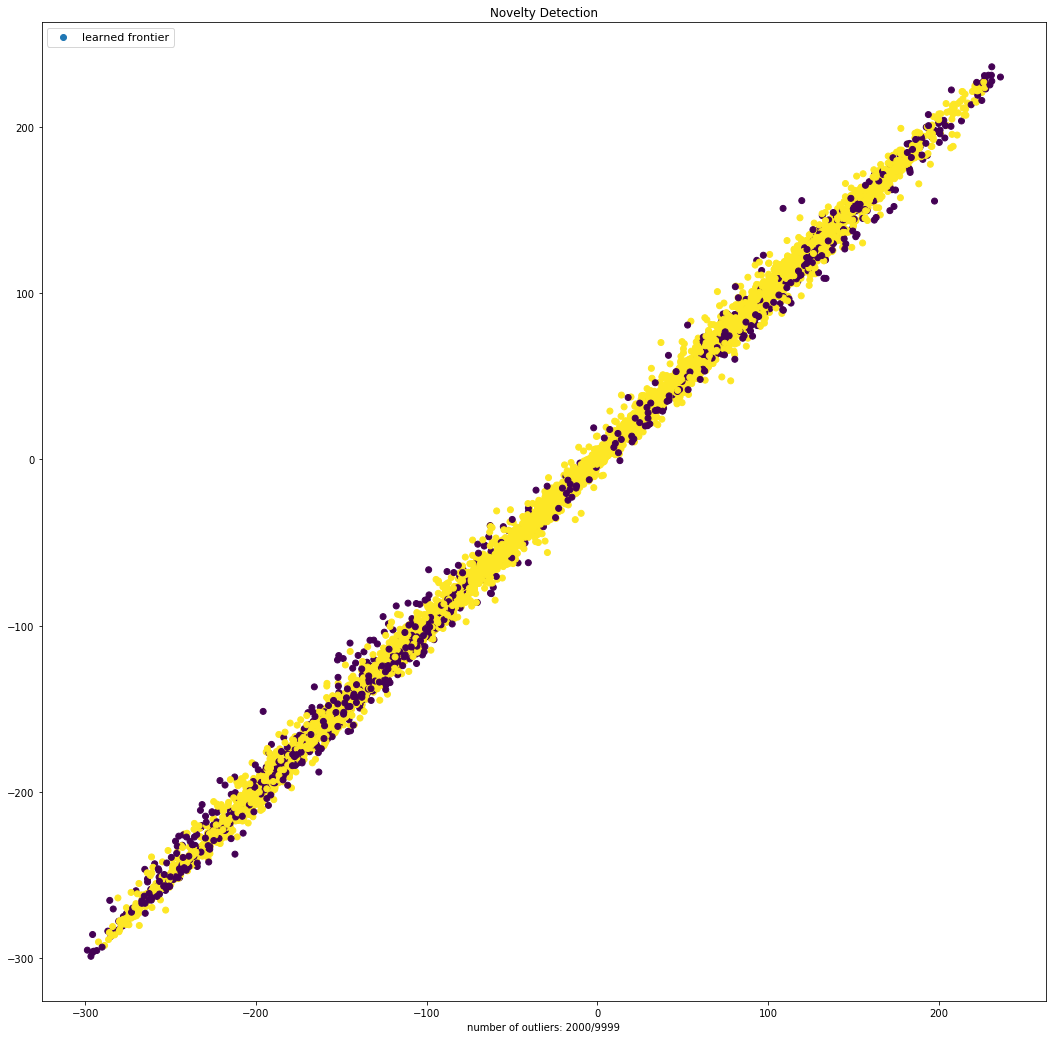

In [10]:
# plot the line, the points, and the nearest vectors to the plane
# Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
# Z = Z.reshape(xx.shape)

plt.figure(figsize=(18, 18))

plt.title("Novelty Detection")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train_ee)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (len(X.index) - y_pred_train_ee.sum() , len(X.index)))

plt.show()

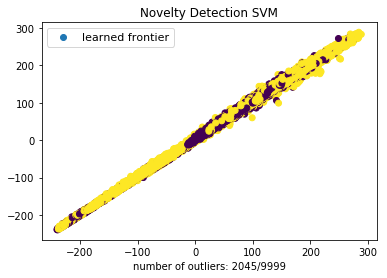

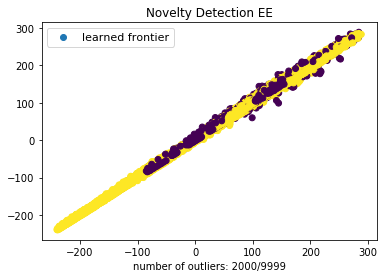

In [12]:
X = final['data_t_road'].iloc[1:10000]

pca = PCA(n_components=2)
pca.fit_transform(X)

min_val =  X.min().min()
max_val =  X.max().max()
axis_val = np.linspace(min_val, max_val, 500)

xx, yy = np.meshgrid(axis_val, axis_val)

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)
y_pred_train = clf.predict(X)

plt.title("Novelty Detection SVM")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (y_pred_train.sum() , len(X.index)))

plt.show()


clf_ee = EllipticEnvelope()
clf_ee.fit(X)
y_pred_train_ee = clf_ee.predict(X)

plt.title("Novelty Detection EE")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train_ee)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (len(X.index) - y_pred_train_ee.sum() , len(X.index)))

plt.show()


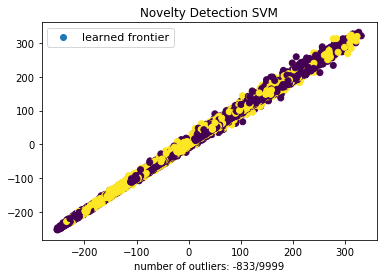

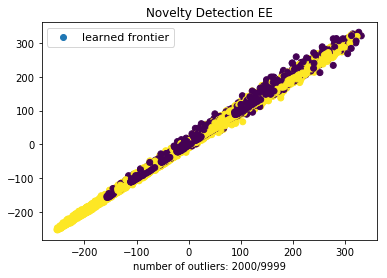

In [13]:
X = final['data_t_underroad'].iloc[1:10000]

pca = PCA(n_components=2)
pca.fit_transform(X)

min_val =  X.min().min()
max_val =  X.max().max()
axis_val = np.linspace(min_val, max_val, 500)

xx, yy = np.meshgrid(axis_val, axis_val)

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)
y_pred_train = clf.predict(X)

plt.title("Novelty Detection SVM")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (y_pred_train.sum() , len(X.index)))

plt.show()


clf_ee = EllipticEnvelope()
clf_ee.fit(X)
y_pred_train_ee = clf_ee.predict(X)

plt.title("Novelty Detection EE")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train_ee)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (len(X.index) - y_pred_train_ee.sum() , len(X.index)))

plt.show()


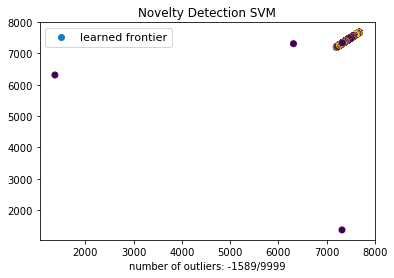

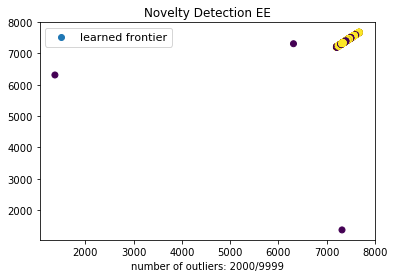

In [14]:
X = final['data_pressure'].iloc[1:10000]

pca = PCA(n_components=2)
pca.fit_transform(X)

min_val =  X.min().min()
max_val =  X.max().max()
axis_val = np.linspace(min_val, max_val, 500)

xx, yy = np.meshgrid(axis_val, axis_val)

clf = svm.OneClassSVM(nu=0.1, kernel="rbf", gamma=0.1)
clf.fit(X)
y_pred_train = clf.predict(X)

plt.title("Novelty Detection SVM")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (y_pred_train.sum() , len(X.index)))

plt.show()


clf_ee = EllipticEnvelope()
clf_ee.fit(X)
y_pred_train_ee = clf_ee.predict(X)

plt.title("Novelty Detection EE")
# plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), 0, 7), cmap=plt.cm.PuBu)
# a = plt.contour(xx, yy, Z, levels=[0], linewidths=2, colors='darkred')
# plt.contourf(xx, yy, Z, levels=[0, Z.max()], colors='palevioletred')




b1 = plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y_pred_train_ee)
# b2 = plt.scatter(X_test[:, 0], X_test[:, 1], c='blueviolet', s=s)
# c = plt.scatter(X_outliers[:, 0], X_outliers[:, 1], c='gold', s=s)
plt.axis('tight')
# plt.xlim((-5, 5))
# plt.ylim((-5, 5))
# plt.legend([a.collections[0], b1],
plt.legend([b1],
           ["learned frontier", "training observations"],
           loc="upper left",
           prop=matplotlib.font_manager.FontProperties(size=11))
plt.xlabel(
    "number of outliers: %d/%d"
    % (len(X.index) - y_pred_train_ee.sum() , len(X.index)))

plt.show()
